## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [3]:
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd

from transformers.models.whisper import WhisperTokenizerFast
from datasets import load_from_disk

import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.eval_dataset_name_to_dataset_group import EVAL_DATASET_NAME_TO_DATASET_GROUP
from evaluation.string_edit_metrics import get_string_edit_metrics_ortho_and_norm
from normalization.whisper_normalization import get_whisper_normalizer
from utils.whisper_hallucinations.get_features import add_features_to_ds, compute_gzip_compression_ratio
from utils.whisper_hallucinations.eval_filter_criterion import eval_filter_criterion
from utils.notebook_utils import listen_to_audio

sns.set_theme(context="paper", style="ticks")

OUTPUT_DIR = Path("notebooks/outputs/8_1_best_kd/librispeech_100h")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## User input

In [4]:
load_from_pickle = True

pickle_filepath = "notebooks/data/librispeech_medium_cached_33p.pkl"
ds_dirpath = "/home/tw581/rds/rds-altaslp-8YSp2LXTlkY/experiments/tw581/cache/huggingface/k_beam_search_cache/librispeech_clean_100h/whisper-medium/k_1/train"

## Load tokenizer

In [5]:
pretrained_model_name_or_path = "openai/whisper-tiny"
tokenizer = WhisperTokenizerFast.from_pretrained(pretrained_model_name_or_path, language="english", task="transcribe")

## Load data

In [6]:
LIST_FEATURES = [
    'text',
    'teacher_text',
    'n_instant_tokens',
    'max_subarray_length',
    'audio_length',
    'n_tokens_labels',
    'n_tokens_teacher',
    'diff_n_tokens',
    'gzip_ratio',
    'teacher_gzip_ratio',
    'diff_gzip_ratio'
]

if load_from_pickle:
    df = pd.read_pickle(pickle_filepath)
else:
    ds = load_from_disk(ds_dirpath)
    ds = ds.select(list(range(ds.num_rows // 3)))
    ds = ds.map(lambda x: {"teacher_text": tokenizer.decode(x["teacher_sequences"], skip_special_tokens=True)})
    ds = add_features_to_ds(ds)
    df = pd.DataFrame({col: ds[col] for col in ds.features.keys() if col in LIST_FEATURES})
    df.to_pickle(pickle_filepath)

In [7]:
df.head()

,text,teacher_text,audio_length,n_tokens_labels,n_tokens_teacher,diff_n_tokens,gzip_ratio,teacher_gzip_ratio,diff_gzip_ratio
0,chapter sixteen i might have told you of the b...,16. I might have told you of the beginning of...,14.530001,52,46,-6,1.328358,1.207143,-0.121215
1,marguerite to be unable to live apart from me ...,Marguerite to be unable to live apart from me...,16.085001,65,61,-4,1.436242,1.347561,-0.088681
2,i wished above all not to leave myself time to...,I wished above all not to leave myself time t...,13.295001,48,46,-2,1.290076,1.230769,-0.059307
3,assumed all at once an appearance of noise and...,assumed all at once an appearance of noise an...,11.125001,37,39,2,1.254098,1.206107,-0.047992
4,nothing is so expensive as their caprices flow...,"Nothing is so expensive as their caprices, fl...",14.080001,51,50,-1,1.311594,1.250000,-0.061594


In [17]:
df.sort_values("diff_n_tokens", ascending=False)[:10]

,text,teacher_text,audio_length,n_tokens_labels,n_tokens_teacher,diff_n_tokens,gzip_ratio,teacher_gzip_ratio,diff_gzip_ratio
8336,ti ti and piti piti piti boom flopped the fly ...,"Pity, pity, pity, pity, pity, pity, pity, pit...",9.830001,30,255,225,1.107527,22.058823,20.951296
4277,flying in among the leaves which to them seem ...,"Flying in among the leaves, which to them see...",10.440001,34,255,221,1.125000,5.918128,4.793128
8911,no opposing desire that should dare to clothe ...,"could ill-brook the opposition of his son, st...",15.515000,52,255,203,1.458333,7.236641,5.778308
2895,the young man may become lord chancellor or at...,"The young man may become Lord Chancellor, or ...",13.080001,52,255,203,1.414474,4.836066,3.421592
985,solemnity and repose it will be perceived no d...,"It will be perceived, no doubt, from what I h...",14.340001,53,255,202,1.354610,6.793940,5.439330
3684,who mistaking us for his fellows had been only...,the old mountain spirits they are so much afr...,14.455001,55,255,200,1.447853,12.784946,11.337093
7733,i and my friends do take good care of our good...,I and my friends do take good care of our goo...,14.365001,65,255,190,1.422819,8.566667,7.143848
1065,although the cars run on wheels the car is rai...,The car is raised in a shaft about one hundre...,14.985001,66,86,20,1.522013,2.285714,0.763702
8910,had been open and bold the general accustomed ...,"The general, accustomed on every ordinary occ...",12.760000,35,53,18,1.200000,1.335484,0.135484
2119,you're him that never bungled nothing you wood...,"You're him that never bungled nothing, you wo...",16.790001,55,71,16,1.376543,1.248731,-0.127812


## First analysis

In [9]:
dict_string_edit_metrics = get_string_edit_metrics_ortho_and_norm(references=df["text"], predictions=df["teacher_text"], norm_fn=get_whisper_normalizer("english"))

dict_string_edit_metrics

{'WER ortho (%)': 26.14240771000568,
 'Sub ortho (%)': 23.032689543096442,
 'Del ortho (%)': 2.659690040151319,
 'Ins ortho (%)': 0.45002812675792236,
 'WER (%)': 4.553585132885463,
 'Sub (%)': 1.789614744323884,
 'Del (%)': 2.253621733945712,
 'Ins (%)': 0.510348654615866}

**Observation:** Using the Whisper normalizer drastically decreased the different string edit metric errors. Since 1-best operated without any normalization, we will focus on the orthographic WER in this study.

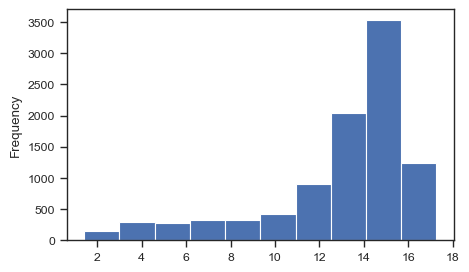

In [10]:
plt.figure(figsize=(5, 3))
df["audio_length"].plot.hist();

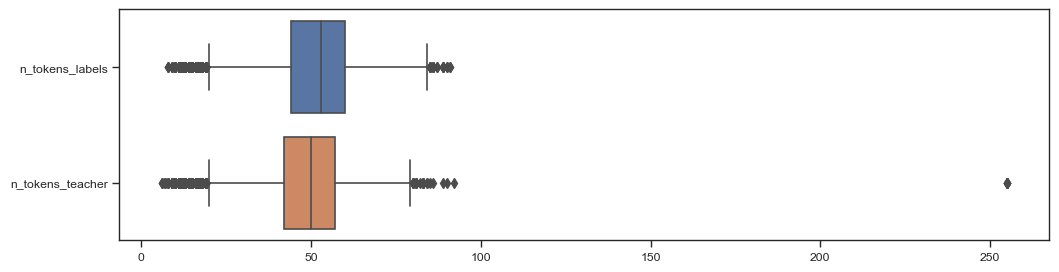

In [11]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=df[["n_tokens_labels", "n_tokens_teacher"]], orient="h");

Figure saved at `notebooks/outputs/8_1_best_kd/librispeech_100h/analysis/n_tokens_teacher_wrt_n_tokens_label.png`.


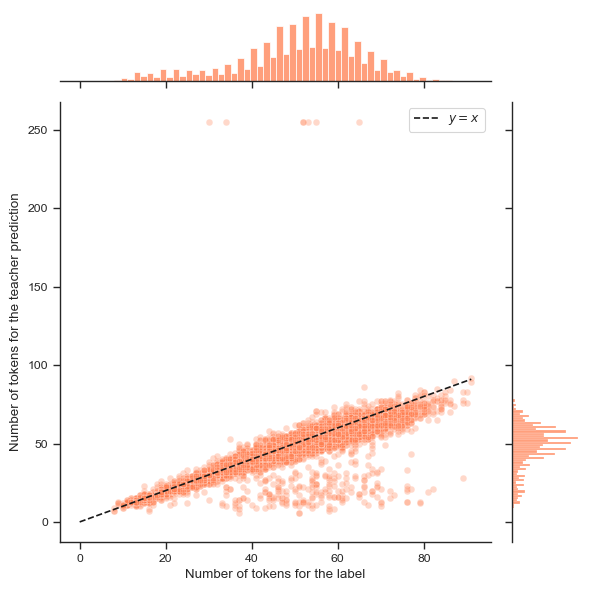

In [29]:
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3, color="coral")
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'k--', label=r"$y=x$")
plt.legend()
plt.xlabel("Number of tokens for the label")
plt.ylabel("Number of tokens for the teacher prediction")
plt.tight_layout()

savepath = OUTPUT_DIR / "analysis" / "n_tokens_teacher_wrt_n_tokens_label.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

In [32]:
df["diff_n_tokens"].describe().to_frame()

,diff_n_tokens
count,9513.000000
mean,-2.532640
std,8.722175
min,-67.000000
25%,-5.000000
50%,-2.000000
75%,1.000000
max,225.000000


In [38]:
df["diff_n_tokens_50+"] = (df["diff_n_tokens"] > 50)
df["diff_n_tokens_50+"].value_counts() / len(df)

False    0.999264
True     0.000736
Name: diff_n_tokens_50+, dtype: float64

In [39]:
df_candidates = df[df["diff_n_tokens_50+"]]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 985
Reference:  solemnity and repose it will be perceived no doubt from what i have already said that the baron was one of those human anomalies now and then to be found who make the science of mystification
Prediction:   It will be perceived, no doubt, from what I have already said, that the Baron was one of those human anomalies, now and then to be found, who make the science of mystification, and the science of the human world, and the science of the human world, and the science of the human world, and the science of the human world, and the science of the human world, and the science of the human world, and the science of the human world, and the science of the human world, and the science of the human world, and the science of the human world, and the science of the human world, and the science of the human world, and the science of the human world, and the science of the human world, and the science of the human world, and the science of the human world, and the science of 

Figure saved at `notebooks/outputs/8_1_best_kd/librispeech_100h/analysis/boxplot_n_diff_tokens.png`.


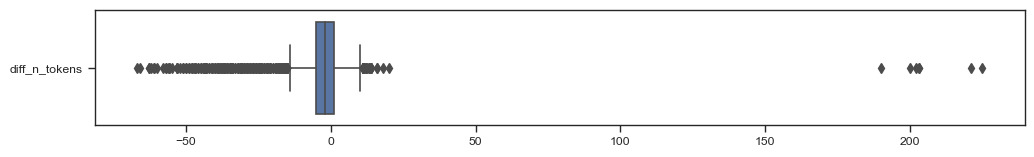

In [13]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h")

savepath = OUTPUT_DIR / "analysis" / "boxplot_n_diff_tokens.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

Figure saved at `notebooks/outputs/8_1_best_kd/librispeech_100h/analysis/diff_n_tokens_wrt_audio_length-librispeech.png`.


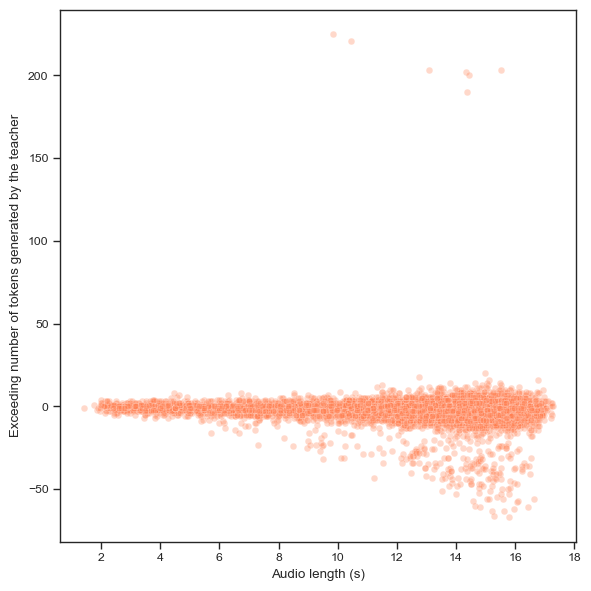

In [24]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x="audio_length", y="diff_n_tokens", alpha=0.3, color="coral")
plt.tight_layout()

plt.xlabel("Audio length (s)")
plt.ylabel("Exceeding number of tokens generated by the teacher")

savepath = OUTPUT_DIR / "analysis" / "diff_n_tokens_wrt_audio_length-librispeech.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")